<a href="https://colab.research.google.com/github/Camicb/Copper-Forecasting/blob/main/Part_2_Copper_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 2. Copper Price Forecasting**

## 1. Introduction
This is the second part of a project aimed to forecast the price of copper. In this case, more types of variables will be considered (Equities, Commodities, Debt and precious metals). Since I'm not an expert in financial markets, I will use the variables and data considered by Mohammad Riazuddin in his [Gold forecasting project](https://towardsdatascience.com/machine-learning-to-predict-gold-price-returns-4bdb0506b132), but I will conduct a different analysis. 

 In order to get the data, I will use the [yfinance](https://aroussi.com/post/python-yahoo-finance) library, which is a financial data library used to download historical market data from Yahoo Finance. The data will range from 2011 to 2021. It is important to note that this library is not official from Yahoo Finances, but works well for the learning purposes of this project. 

 The notebook with the whole data extraction process can be find [here](https://github.com/Camicb/Copper-Forecasting/blob/main/Data_extraction.ipynb). In this notebook I will the load that data, already collected and saved as csv file.


## 2. Import Required Libraries

In [1]:
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip -q
! jupyter nbextension enable --py widgetsnbextension 
! pip install scipy -U -q
! pip install statsmodels -U -q
! pip install pystan -q
! pip install fbprophet -q
! pip install pmdarima -q
! pip install auto-ts -q
! pip install xgboost -q

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [2]:
# Importing libraries
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno 
from pandas_profiling import ProfileReport
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from datetime import datetime
from auto_ts import auto_timeseries
from sklearn.metrics import mean_squared_error


Imported auto_timeseries version:0.0.36. Call by using:
model = auto_timeseries(score_type='rmse',
                time_interval='M',
                non_seasonal_pdq=None, seasonality=False, seasonal_period=12,
                model_type=['best'],
                verbose=2)
model.fit(traindata, ts_column,target)
model.predict(testdata, model='best')



In [3]:
# For reproducible results
from numpy.random import seed
seed(2021)


## 3. Exploratory Data Analysis and Preprocessing

In [4]:
# Load data
price = pd.read_csv('https://raw.githubusercontent.com/Camicb/Copper-Forecasting/main/price.csv')

In [5]:
# Inspecting the new dataset
price.tail(3)

,Date,Copper,Gold,Silver,Crude Oil,S&P500,Russel 2000 Index,10 Yr US T-Note futures,2 Yr US T-Note Futures,Platinum,Dollar Index,Volatility Index,MSCI EM ETF,Euro USD,Euronext100,Nasdaq
2669,2021-03-26,4.0785,1732.199951,25.091999,60.970001,3974.540039,2221.479980,131.765625,110.460938,1177.500000,92.775002,18.860001,53.270000,1.177662,1184.050049,13138.730469
2670,2021-03-29,4.0430,1712.099976,24.747000,61.560001,3971.090088,2158.679932,131.359375,110.457031,1181.300049,92.956001,20.740000,52.900002,1.178800,1187.949951,13059.650391
2671,2021-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.177101,NaN,NaN


In [6]:
# Inspecting variables
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2672 entries, 0 to 2671
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Date                     2672 non-null   object 
 1   Copper                   2553 non-null   float64
 2   Gold                     2553 non-null   float64
 3   Silver                   2553 non-null   float64
 4   Crude Oil                2554 non-null   float64
 5   S&P500                   2576 non-null   float64
 6   Russel 2000 Index        2576 non-null   float64
 7   10 Yr US T-Note futures  2552 non-null   float64
 8   2 Yr US T-Note Futures   2554 non-null   float64
 9   Platinum                 2543 non-null   float64
 10  Dollar Index             2552 non-null   float64
 11  Volatility Index         2576 non-null   float64
 12  MSCI EM ETF              2576 non-null   float64
 13  Euro USD                 2647 non-null   float64
 14  Euronext100             

In [7]:
# Fixing datatypes
price['Date'] = pd.to_datetime(price['Date'])
price.index = price['Date']

In [8]:
# Statistical report
data = price.loc[ : , price.columns != 'Date'] # don't consider date for the analysis
profile = ProfileReport(data, html={'style': {'full_width': True, 'primary_color': '#30b6c2'}},  samples=None, missing_diagrams=None, interactions=None)
profile.to_file("report.html")
profile.to_notebook_iframe()

Summarize dataset:   0%|          | 0/29 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

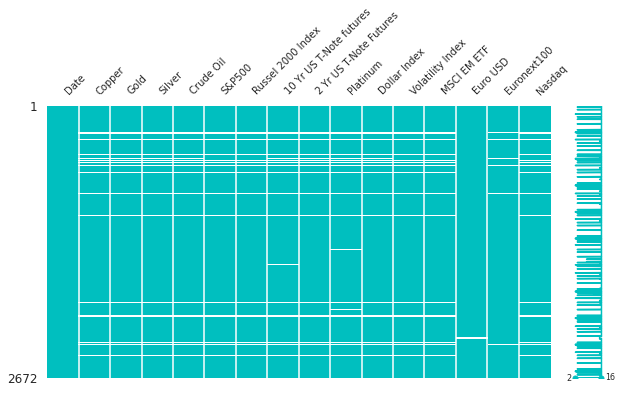

In [9]:
# Visualization of missing values
msno.matrix(price, figsize=(10,5), fontsize=10, color=(0.0, 0.75, 0.75))

In [10]:
# Filling the empty values with the previous valid one
price.fillna(method='ffill', axis=0, inplace=True)

# Droping highly correlated variables
price.drop(['S&P500', 'Russel 2000 Index', 'Euronext100'], axis=1, inplace=True)

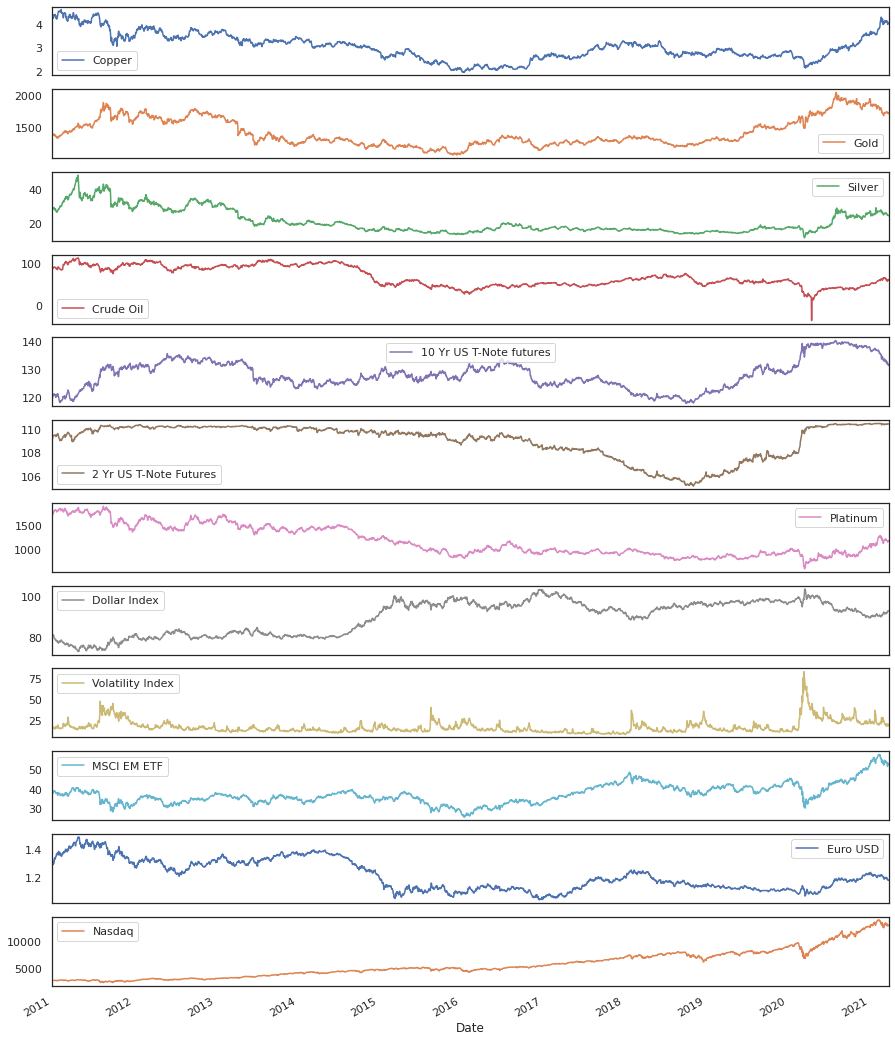

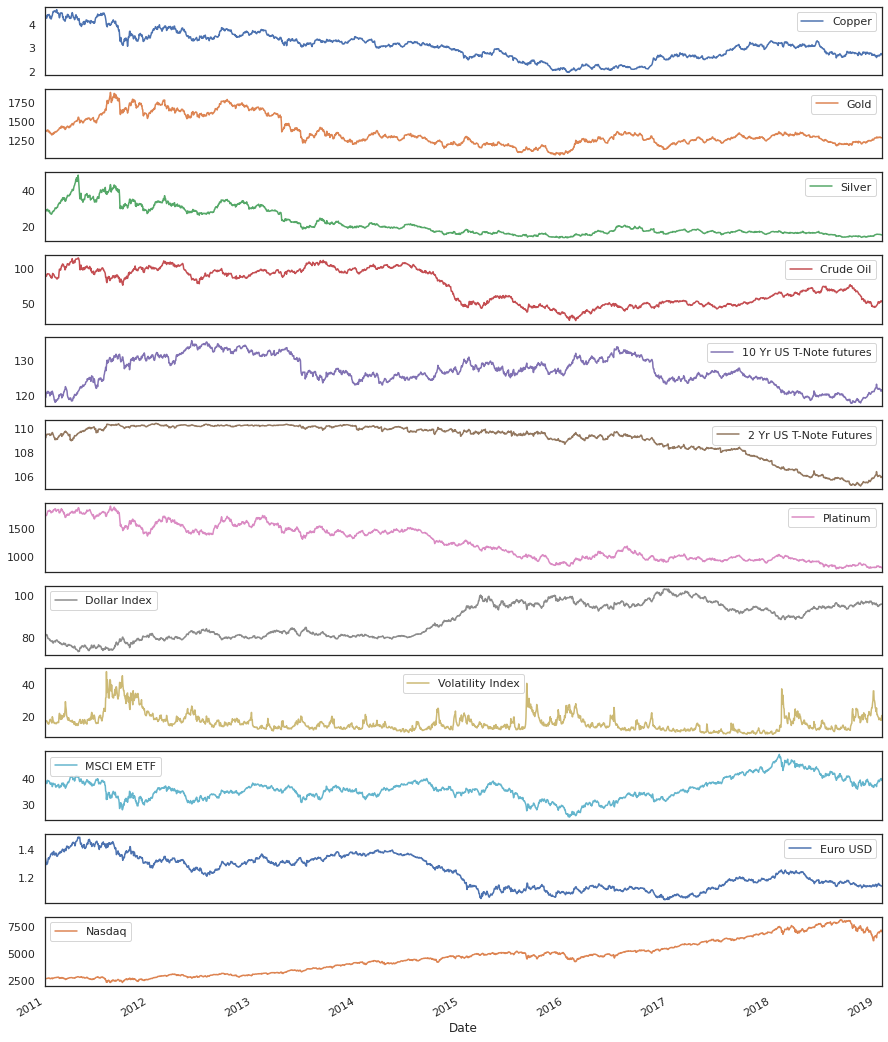

In [11]:
# Visualizations
mpl.rcParams['figure.figsize'] = (15, 20)
mpl.rcParams['axes.grid'] = False

data = price.loc[ : , price.columns != 'Date']
plot_cols = data.columns
plot_features = price[plot_cols]
plot_features.index = price['Date']
_ = plot_features.plot(subplots=True)

# Visualization of a subsample ~ 10%  
plot_features = price[plot_cols][:-570]
plot_features.index = price['Date'][:-570]
_ = plot_features.plot(subplots=True)

## 4. Modeling

I will try different models with the library [Auto_TimeSerie](https://github.com/AutoViML/Auto_TS). 

Auto_TimeSerie is a complex model building utility for time series data.  Auto_Timeseries will rapidly build predictive models based on Statsmodels ARIMA, Seasonal ARIMA, Facebook Prophet and Scikit-Learn ML. It will automatically select the best model which gives best score specified. 
I will consider a business day time interval. 


In [12]:
# Creating model
model = auto_timeseries(score_type='rmse', 
                        time_interval='B', 
                        seasonal_period=30,
                        model_type=['best'], 
                        verbose=2)

In [13]:
# Splitting data
n = len(price)
train_data = train = price[0:int(n*0.9)]  # 90% data
test_data = price[int(n*0.9):]            # 10% data

Start of Fit.....
Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Results of Augmented Dickey-Fuller Test:
+-----------------------------+------------------------------+
|                             | Dickey-Fuller Augmented Test |
+-----------------------------+------------------------------+
|        Test Statistic       |      -2.362895215757063      |
|           p-value           |      0.1524839095391931      |
|          #Lags Used         |             0.0              |
| Number of Observations Used |            2403.0            |
|     Critical Value (1%)     |     -3.4330742193886445      |
|     Critical Value (5%)     |     -2.8627435243022283      |
|     Critical Value (10%)    |      -2.567410686207021      |
+-----------------------------+------------------------------+
 this series is non-stationary. Trying test again after differencing...
After differencing=1, results of Augmented Dickey-Fuller Test:
+-----------------

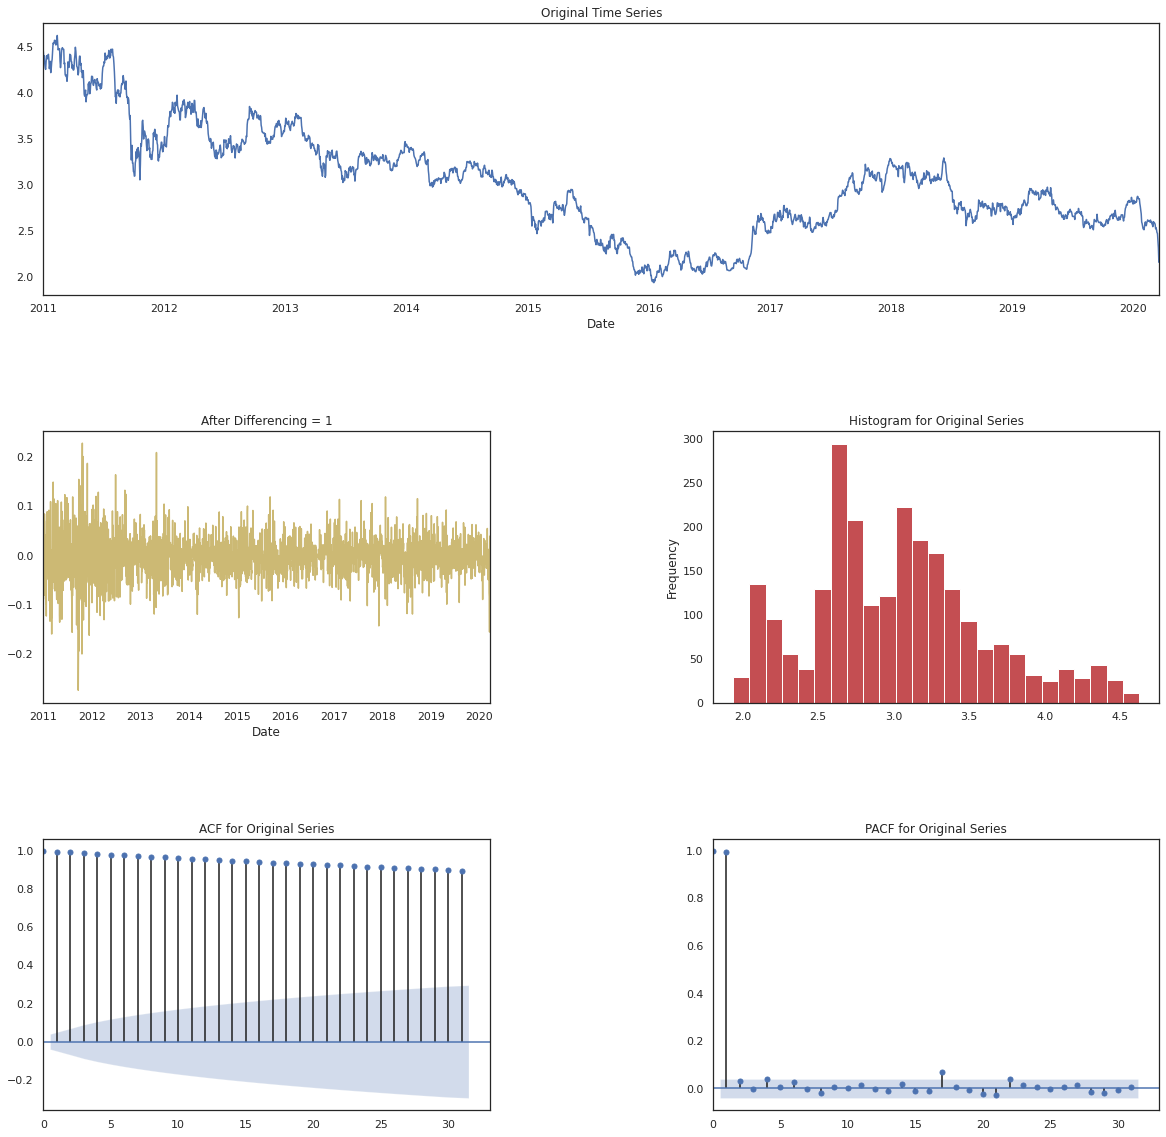

Time Interval is given as B
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
    Fit-Predict data (shape=(2404, 13)) with Confidence Interval = 0.95...
  Starting Prophet Fit
      No seasonality assumed since seasonality flag is set to False
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 5

Fold Number: 1 --> Train Shape: 2379 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 0.06
    Std Deviation of actuals = 0.01
    Normalized RMSE = 972%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 2384 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 0.05
    Std Deviation of actuals = 0.02
    Normalized RMSE = 279%
Cross Validation window: 2 completed

Fold Number: 3 --> Train Shape: 2389 Test Shape: 5
    Root Mean Squared Error predictions vs actuals = 0.03
    Std Deviation of actuals = 0.02
    Norm

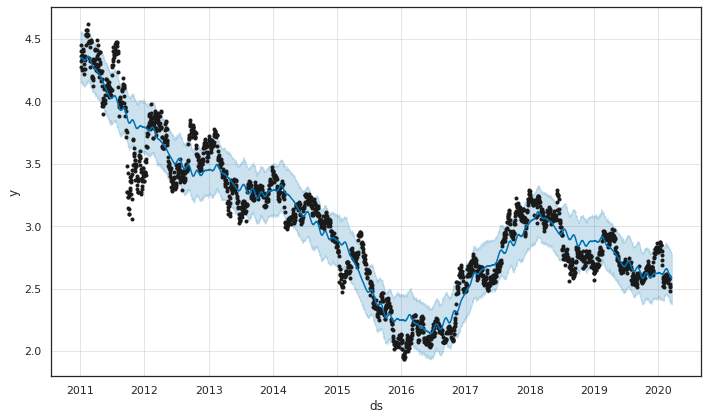

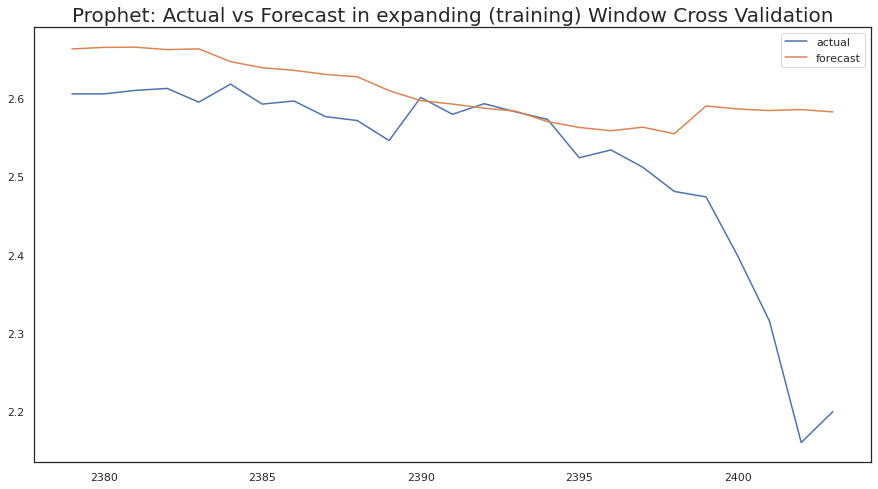

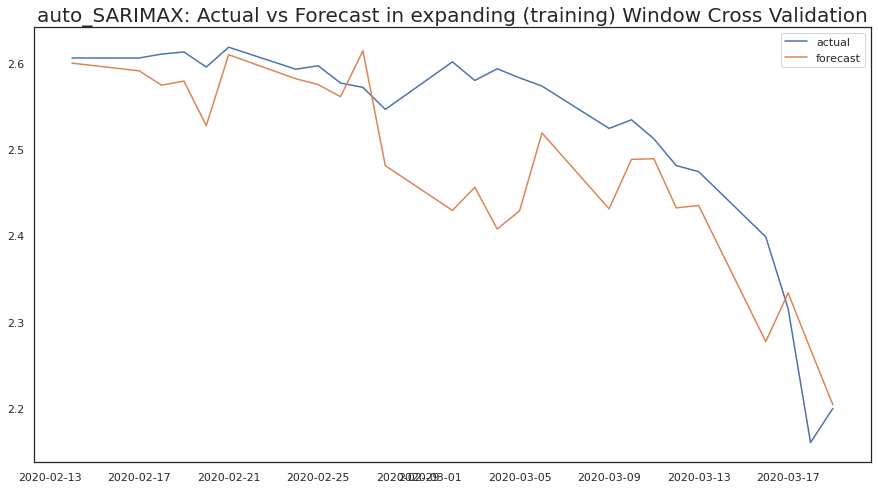

In [14]:
# Fitting model
ts_column = 'Date'
target = 'Copper'

model.fit( traindata=train_data, ts_column=ts_column, target=target, cv=5)

In [15]:
# Evaluate results
model.get_leaderboard()

,name,rmse
1,auto_SARIMAX,0.068121
0,Prophet,0.095550
2,ML,inf


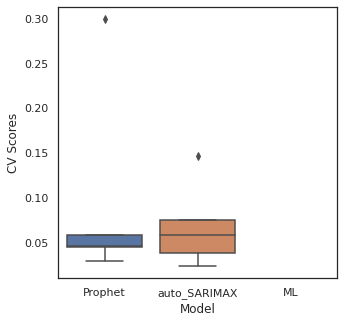

In [16]:
# Plot results
mpl.rcParams['figure.figsize'] = (5, 5)
mpl.rcParams['axes.grid'] = False
model.plot_cv_scores()

In [17]:
# Make sure all models have the same number of CV folds
model.get_cv_scores()

,Model,CV Scores
0,Prophet,0.058222
1,Prophet,0.045911
2,Prophet,0.029260
3,Prophet,0.045033
4,Prophet,0.299325
5,auto_SARIMAX,0.038144
6,auto_SARIMAX,0.023334
7,auto_SARIMAX,0.146381
8,auto_SARIMAX,0.057675
9,auto_SARIMAX,0.075073


In [25]:
# Predictions
future_predictions_fb = model.predict(
    testdata=test_data.drop(columns=target),
    model='Prophet')

future_predictions_fb.index = future_predictions_fb['ds']

Building Forecast dataframe. Forecast Period = 268


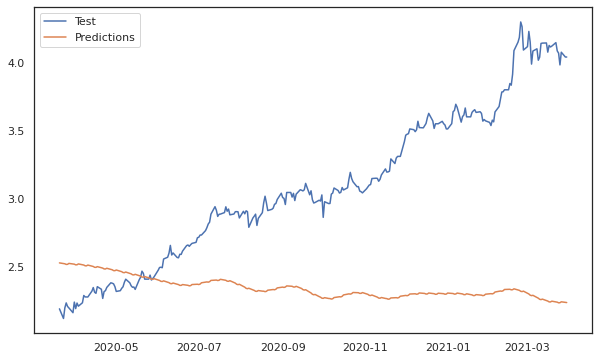

In [26]:
# Visualizing results
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.grid'] = False
plt.plot(test_data['Copper'], label='Test')
plt.plot(future_predictions_fb['yhat'], label='Predictions')
plt.legend()

In [ ]:
# Predictions with best model
future_predictions = model.predict(
    testdata=test_data.drop(columns=target),
    model='auto_SARIMAX')

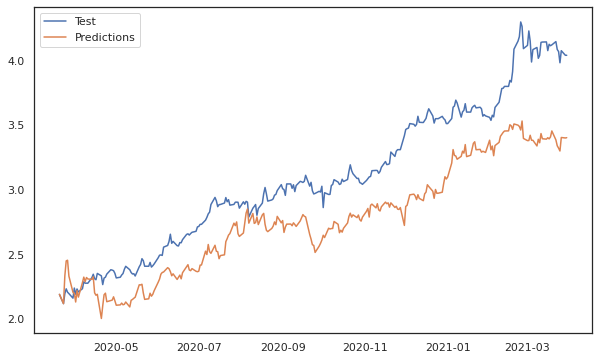

In [19]:
# Visualizing results
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.grid'] = False
plt.plot(test_data['Copper'], label='Test')
plt.plot(future_predictions['yhat'], label='Predictions')
plt.legend()

In [20]:
# Metrics
mean_squared_error(test_data['Copper'], future_predictions['yhat'])

0.144224576157568

# 5. Conclusions

- Best model is a Seasonal SARIMAX(1,0,0)*(0,0,0,30), aic = -9126.700
- Best model give a little pessimist result, but copper prices don't have seasonality nor follow a clear trend so results are very good, especially compared to the first part of the project. 
- Prophet gave good results looking at the metrics, but the visualization shows the real differences between the predicted and the real values.
- VAR y ML models didn't work, but other model results were good so I will not try to create new ones.
- Recurrent Neural Networks  (RNN) with Gated Recurrent Unit (GRU) were an option I considered to try if traditional methods fail, but since they did a good job I will not try modeling with neural networks.